<a href="https://colab.research.google.com/github/shaniklein/Deep-Learning-Ass1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1. Music Century Classification

**Deadline**: Sunday, April 4th, by 9pm.

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 



In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together. 

To process and read the data, we use the popular `pandas` package for data analysis.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [2]:
load_from_drive = False

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/My Drive/YearPredictionMSD.txt.zip' # TODO - UPDATE ME WITH THE TRUE PATH!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [3]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [4]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [5]:
df.head(20)

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,1,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,1,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,1,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,1,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model will perform in practice on a song it hasn't learned about.)

In [6]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()

# Write your explanation here
'''
To evaluate our model correctly we want to know how well the model will perform in practice on a song it hasn't learned about.
Using some songs from an artist in the training set, and other songs from the same artist in the test set
can lead to a situation where the The model will learn specific featues of the singer
such as the singer's voice and will predict the decade according to the singer voice.
In that case we will get a good test accuracy because the singer's songs are in the test data,hence the model will predict correctly,
but that does not mean the model will perfom the same on different singers
'''


"\nTo evaluate our model correctly we want to know how well the model will perform in practice on a song it hasn't learned about.\nUsing some songs from an artist in the training set, and other songs from the same artist in the test set\ncan lead to a situation where the The model will learn specific featues of the singer\nsuch as the singer's voice and will predict the decade according to the singer voice.\nIn that case we will get a good test accuracy because the singer's songs are in the test data,hence the model will predict correctly,\nbut that does not mean the model will perfom the same on different singers\n"

### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [7]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds

Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [8]:
'''
The conceptual idea is that test data is supposed to mimic new, previously unseen data after training. 
If we normalize the test data separately we can cause data leakage,
meaing we are introducing future information into the training explanatory variables (i.e. the mean and variance).
Therefore, we should perform feature normalisation over the training data,
and then perform normalisation on testing data me using the mean and variance of training explanatory variables.
In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.
'''

'\nThe conceptual idea is that test data is supposed to mimic new, previously unseen data after training. \nIf we normalize the test data separately we can cause data leakage,\nmeaing we are introducing future information into the training explanatory variables (i.e. the mean and variance).\nTherefore, we should perform feature normalisation over the training data,\nand then perform normalisation on testing data me using the mean and variance of training explanatory variables.\nIn this way, we can test and evaluate whether our model can generalize well to new, unseen data points.\n'

### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [9]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# Write your explanation here
'''
First , we should limit how many times we use the test set becaus we want to evaluate the model according to unseen data.
If we use the test data and change our training according to the test data we will get good test accuracy but it won't be generalize
to unseen data, hence we sould use the validation data insead.
We use validation set during the model building proccess so we can give an estimate of model skill while tuning model’s hyperparameters.
The validation dataset is different from the test dataset , both datasets are held back from the training of the model,
but the validation set used to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models.
'''


"\nFirst , we should limit how many times we use the test set becaus we want to evaluate the model according to unseen data.\nIf we use the test data and change our training according to the test data we will get good test accuracy but it won't be generalize\nto unseen data, hence we sould use the validation data insead.\nWe use validation set during the model building proccess so we can give an estimate of model skill while tuning model’s hyperparameters.\nThe validation dataset is different from the test dataset , both datasets are held back from the training of the model,\nbut the validation set used to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models.\n"

## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [10]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  epsilon=1e-05
  return -t * np.log(y+epsilon) - (1 - t) * np.log(1 - y+epsilon)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by: 
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [11]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
  z=np.dot(X,w)+b
  y=sigmoid(z)
  return y

In [12]:
 pred(np.zeros(90), 1, np.ones([2, 90]))

array([0.73105858, 0.73105858])

In [13]:
 pred(np.zeros(90), 1, train_norm_xs)

array([0.73105858, 0.73105858, 0.73105858, ..., 0.73105858, 0.73105858,
       0.73105858])

### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [14]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """
  # Your code goes here
  N=len(y)
  epsilon=1e-05
  dLdy=(-t/(y+epsilon)+(1-t)/(1-y+epsilon))/N 
  sig_d=y*(1-y)
  dydb=sig_d
  dLdb=np.dot(dydb,dLdy)
  dydw=sig_d*X.T
  dLdw=np.dot(dydw,dLdy)
  return (dLdw,dLdb)

# **Explenation on Gradients**




**Add here an explaination on how the gradients are computed**:

Write your explanation here. Use Latex to write mathematical expressions. [Here is a brief tutorial on latex for notebooks.](https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/)



### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [15]:
# helper method to compute analytical deriviate according to parameter_to_check.
def compute_analytical_deriviate(w,b,t,X,parameter_to_check,h=1e-05):
  y= pred(w, b, X)
  L=cost(y,t)
  if parameter_to_check=='b':
    y_plus=pred(w,b+h,X)
    L_plus=cost(y_plus,t)
    deriviate=(L_plus-L)/h

  elif parameter_to_check=='w':
    L_plus=np.zeros(len(w))
    deriviate=np.zeros(len(w))
    for i in range(len(w)):
      # Compute cost of w[i] + h
      w_plus = np.copy(w)
      w_plus[i] = w_plus[i] + h
      y_plus=pred(w_plus,b,X)
      L_plus[i]=cost(y_plus,t)
      deriviate[i] = (L_plus[i]-L)/h
  
  else:
    raise Exception('parameter_to_check: {} is not define - has to be b or w'.format(parameter_to_check))
  
  return deriviate

In [16]:
# helper class to print nice outputs
class txt:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def make_bold(text):
    return txt.BOLD+ text + txt.END

def make_underline(text):
    return txt.UNDERLINE+ text + txt.END

In [17]:
w=np.zeros(90)
h=1e-05
b=1
t=np.array([1,1])
X=np.ones([2, 90])
y= pred(w, b, X)
dw,db=derivative_cost(X,y,t)


In [18]:
analytical_deriviate=compute_analytical_deriviate(w,b,t,X,'b')
print(make_underline("analytical_deriviate according to b :"), analytical_deriviate)
print(make_underline("our deriviate according to b:"),db)

analytical_deriviate according to b : -0.2689367595898329
our deriviate according to b: -0.2689377426259042


In [19]:
h = 10**(-9);

# calculating random w and b values
w=np.random.rand(90)
b=np.random.rand(1)

# choose number of observations
t=(train_ts[:3]).squeeze()
X=train_norm_xs[:3]

# calculate the derivative by the algorythm
y=pred(w, b, X)
dLdw_algo,dLdb_algo=derivative_cost(X,y,t)

# calculate the derivative analytically
y_anal=pred(w, b+h, X)
dLdb_anal = (cost(y_anal, t) - cost(y, t))/h

r1 = dLdb_anal
r2 = dLdb_algo
print("The analytical results is -", r1)
print("The algorithm results is - ", r2)


The analytical results is - -0.5009135328748471
The algorithm results is -  -0.5009134862324925


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [20]:
# Your code goes here. You might find this below code helpful: but it's
# up to you to figure out how/why, and how to modify the code
analytical_deriviate=compute_analytical_deriviate(w,b,t,X,'w')
print(make_underline("analytical_deriviate according to w is:"), analytical_deriviate,'\n')
print(make_underline("our deriviate according to w :"), dLdw_algo)


analytical_deriviate according to w is: [-0.11590938  0.21165501  0.74199513  0.91933662  0.22694135  0.26048152
  0.0481264   0.42637953 -0.28824927  0.56378193  0.23812842 -0.08252547
 -0.34530368  0.20417594  0.53263913  0.25342102  0.61806905  0.30461015
  0.56604834  0.36089667  0.3037171   0.30846243  0.40674147  0.27355813
 -0.17108403  0.16708386  0.10482871  0.04864642 -0.07341692 -0.3033325
  0.08893864 -0.23238923  0.37529976 -0.12855133 -0.30212392 -0.1443064
  0.09871745  0.52229112 -0.0902386  -0.00251416 -0.04628838 -0.14563484
  0.14819945  0.16863075  0.2247953  -0.34524139 -0.14501591  0.27387886
 -0.32391931 -0.03869126 -0.34215191  0.3397931  -0.21348963  0.21053402
  0.06573456  0.09956056  0.13563359  0.43747025 -0.16111254  0.45127288
  0.28782626 -0.00395896 -0.06185248  0.01936739 -0.13866923  0.03214287
  0.49317239  0.03306528  0.12492842  0.05211278 -0.22291885 -0.1891107
 -0.5327951  -0.25732243 -0.16263427  0.25760484 -0.24765166 -0.09709645
 -0.17356493  

### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent. 
Complete the following code that will run stochastic: gradient descent training:

In [21]:
def run_gradient_descent(w0, b0, mu=0.1, batch_size=100, max_iters=100):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  w = w0
  b = b0
  iter = 0
  l=[]
  accuracies=[]
  losses=[]

  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    reindex = np.random.permutation(len(train_norm_xs))
    # train_xs = train_xs[reindex]
    train_norm_xs_local = train_norm_xs[reindex]
    train_ts_local = train_ts[reindex]


    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs_local[i:(i + batch_size)]
      t = train_ts_local[i:(i + batch_size), 0]

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      y=pred(w,b,X)
      # update w and b
      dw,db=derivative_cost(X,y,t)
      w-=mu*dw
      b-=mu*db

      # increment the iteration count
      iter += 1
      # compute and print the *validation* loss and accuracy
      if (iter % 10 == 0):
        y_val=pred(w,b,val_norm_xs)
        val_cost = cost(y_val,val_ts.squeeze())
        val_acc = get_accuracy(y_val,val_ts.squeeze())
        print("Iter %d. [Val Acc %.0f%%, Loss %f]" % (
                iter, val_acc * 100, val_cost))
        losses.append(val_cost)
        accuracies.append(val_acc)

      if iter >= max_iters:
        break

      # Think what parameters you should return for further use
      
  return w,b,losses



### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

mu= 0.01 :
Iter 10. [Val Acc 54%, Loss 2.839941]
Iter 20. [Val Acc 54%, Loss 2.815553]
Iter 30. [Val Acc 54%, Loss 2.795140]
Iter 40. [Val Acc 54%, Loss 2.775568]
Iter 50. [Val Acc 54%, Loss 2.752097]
Iter 60. [Val Acc 54%, Loss 2.727479]
Iter 70. [Val Acc 55%, Loss 2.703303]
Iter 80. [Val Acc 55%, Loss 2.683224]
Iter 90. [Val Acc 55%, Loss 2.658374]
Iter 100. [Val Acc 55%, Loss 2.637385]
-------------------------
mu= 0.5 :
Iter 10. [Val Acc 58%, Loss 2.095756]
Iter 20. [Val Acc 60%, Loss 1.832866]
Iter 30. [Val Acc 61%, Loss 1.650904]
Iter 40. [Val Acc 63%, Loss 1.471819]
Iter 50. [Val Acc 64%, Loss 1.312448]
Iter 60. [Val Acc 65%, Loss 1.185281]
Iter 70. [Val Acc 66%, Loss 1.060972]
Iter 80. [Val Acc 66%, Loss 0.964500]
Iter 90. [Val Acc 67%, Loss 0.887548]
Iter 100. [Val Acc 68%, Loss 0.824424]
-------------------------
mu= 0.9 :
Iter 10. [Val Acc 68%, Loss 0.774726]
Iter 20. [Val Acc 68%, Loss 0.748569]
Iter 30. [Val Acc 69%, Loss 0.713251]
Iter 40. [Val Acc 70%, Loss 0.673696]
Ite

Text(0.5, 1.0, 'The affect of mu on the convergence')

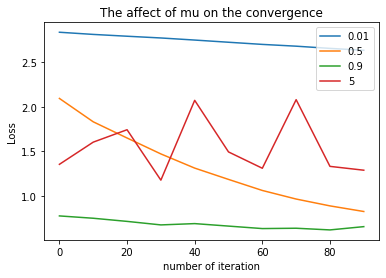

In [22]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

mus=[0.01,0.5,0.9,5]
for mu in mus:
  print(make_bold("mu="),mu,":")
  w,b,losses=run_gradient_descent(w0,b0,mu)
  print("-------------------------")
  plt.plot(range(0,100,10),losses)

plt.legend(mus,loc='upper right')
plt.xlabel("number of iteration")
plt.ylabel("Loss")
plt.title("The affect of mu on the convergence")

**Explain and discuss your results here:**


### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.

batch_size= 10 :
Iter 10. [Val Acc 55%, Loss 2.471309]
Iter 20. [Val Acc 56%, Loss 2.114539]
Iter 30. [Val Acc 57%, Loss 1.776938]
Iter 40. [Val Acc 59%, Loss 1.612472]
Iter 50. [Val Acc 62%, Loss 1.489996]
Iter 60. [Val Acc 64%, Loss 1.291837]
Iter 70. [Val Acc 64%, Loss 1.311725]
Iter 80. [Val Acc 64%, Loss 1.229972]
Iter 90. [Val Acc 64%, Loss 1.148364]
Iter 100. [Val Acc 65%, Loss 1.090638]
-------------------------
batch_size= 70 :
Iter 10. [Val Acc 69%, Loss 0.894083]
Iter 20. [Val Acc 69%, Loss 0.841899]
Iter 30. [Val Acc 70%, Loss 0.775968]
Iter 40. [Val Acc 69%, Loss 0.764305]
Iter 50. [Val Acc 70%, Loss 0.727373]
Iter 60. [Val Acc 70%, Loss 0.686323]
Iter 70. [Val Acc 71%, Loss 0.648196]
Iter 80. [Val Acc 71%, Loss 0.650106]
Iter 90. [Val Acc 71%, Loss 0.632097]
Iter 100. [Val Acc 71%, Loss 0.644383]
-------------------------
batch_size= 100 :
Iter 10. [Val Acc 72%, Loss 0.612246]
Iter 20. [Val Acc 72%, Loss 0.608891]
Iter 30. [Val Acc 72%, Loss 0.608706]
Iter 40. [Val Acc 70

Text(0.5, 1.0, 'The affect of batch size on the convergence')

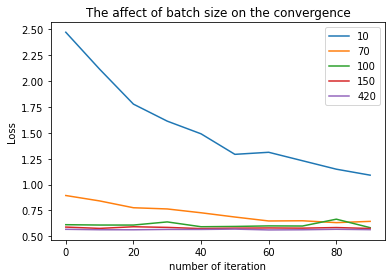

In [23]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

mu=0.5
batches=[10,70,100,150,420]
for batch_size in batches:
  print(make_bold("batch_size="),batch_size,":")
  w,b,losses=run_gradient_descent(w0,b0,mu,batch_size)
  print("-------------------------")
  plt.plot(range(0,100,10),losses)

plt.legend(batches,loc='upper right')
plt.xlabel("number of iteration")
plt.ylabel("Loss")
plt.title("The affect of batch size on the convergence")

**Explain and discuss your results here:**




### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [24]:
# Write your code here
best_w,best_b,_=run_gradient_descent(w0,b0,0.5,150)
train_ys=pred(best_w,best_b,train_norm_xs)
test_ys=pred(best_w,best_b,test_norm_xs)
val_ys=pred(best_w,best_b,val_norm_xs)


train_acc = get_accuracy(train_ys,train_ts)
val_acc =  get_accuracy(val_ys,val_ts)
test_acc =  get_accuracy(test_ys,test_ts)

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)


Iter 10. [Val Acc 72%, Loss 0.572899]
Iter 20. [Val Acc 73%, Loss 0.569510]
Iter 30. [Val Acc 72%, Loss 0.587065]
Iter 40. [Val Acc 73%, Loss 0.567382]
Iter 50. [Val Acc 73%, Loss 0.569670]
Iter 60. [Val Acc 72%, Loss 0.577967]
Iter 70. [Val Acc 72%, Loss 0.579664]
Iter 80. [Val Acc 73%, Loss 0.574275]
Iter 90. [Val Acc 72%, Loss 0.579416]
Iter 100. [Val Acc 72%, Loss 0.579088]
train_acc =  0.7202083559938605  val_acc =  0.71692  test_acc =  0.7156110788301375


**Explain and discuss your results here:**


### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [25]:
import sklearn.linear_model

model = sklearn.linear_model.LogisticRegression()
model.fit(train_norm_xs,train_ts)
train_ys=model.predict(train_norm_xs)
test_ys=model.predict(test_norm_xs)
val_ys=model.predict(val_norm_xs)

train_acc = get_accuracy(train_ys,train_ts)
val_acc =  get_accuracy(val_ys,val_ts)
test_acc =  get_accuracy(test_ys,test_ts)

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_acc =  0.7328064005414355  val_acc =  0.73148  test_acc =  0.7265736974627155


**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**
